# <u>Poisson Mixture Model with Gamma Prior on Rate Parameters</u>

This model describes a dataset **X** with *n* samples, *d* features, and *k* clusters. It assumes each data point is generated from a mixture of Poisson distributions, where each sample belongs to one of the *k* clusters. For every feature in a sample, the observed count follows a Poisson distribution whose rate parameter depends on both the cluster assigned to the sample and the specific feature being measured. 

The rate parameters for each cluster-feature combination are not fixed but instead drawn from a Gamma distribution. This Gamma prior has two hyperparameters: a shape parameter (*α*) and a rate parameter (*β*), both positive values. 

The model has a hierarchical structure: cluster assignments determine which Poisson component generates the data, while all rate parameters share the same underlying Gamma distribution.

# Mathematical Formulas and Theory Used

---

## 1. **Poisson Mixture Model with Gamma Prior**

Given a dataset **X** with *n* samples, *d* features, and *k* clusters, each data point is generated as follows:

### **Cluster Assignment**
Each sample is assigned to a cluster:
$$
z_n \sim \text{Categorical}(\pi_1, \ldots, \pi_k)
$$
where $z_n$ is the cluster assignment for sample $n$.

---

### **Gamma Prior on Poisson Rate Parameters**
For each cluster $j$ and feature $i$, the Poisson rate parameter $\lambda_{j,i}$ is drawn from a Gamma distribution:
$$
\lambda_{j,i} \sim \text{Gamma}(\alpha, \beta)
$$

**Gamma PDF:**
$$
p(\lambda) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha-1} e^{-\beta \lambda}, \quad \lambda > 0
$$
- $\alpha$ = shape parameter
- $\beta$ = rate parameter (inverse scale)
- $\Gamma(\alpha)$ = gamma function

**Mean and Variance of Gamma:**
$$
\mathbb{E}[\lambda] = \frac{\alpha}{\beta}
$$
$$
\text{Var}[\lambda] = \frac{\alpha}{\beta^2}
$$

---

### **Poisson Likelihood**
Given $\lambda_{j,i}$, the observed count for sample $n$ (assigned to cluster $z_n$) and feature $i$ is:
$$
X_{n,i} \sim \text{Poisson}(\lambda_{z_n, i})
$$

**Poisson PMF:**
$$
P(X_{n,i} = x \mid \lambda_{z_n,i}) = \frac{\lambda_{z_n,i}^x e^{-\lambda_{z_n,i}}}{x!}
$$

---

## 2. **Log-Likelihood Calculation**

For all samples and features, the log-likelihood is:
$$
\log P(X \mid \lambda, z) = \sum_{n=1}^N \sum_{i=1}^d \left[ X_{n,i} \log \lambda_{z_n,i} - \lambda_{z_n,i} - \log(X_{n,i}!) \right]
$$

Or, for each sample $n$ (with cluster assignment $z_n$):
$$
\log P(X_n \mid \lambda_{z_n}) = \sum_{i=1}^d \left[ X_{n,i} \log \lambda_{z_n,i} - \lambda_{z_n,i} - \log(X_{n,i}!) \right]
$$

---



## 3. **Interpretation of Gamma Variance and Cluster Separability**

- **High Gamma variance ($\text{Var}[\lambda] = \frac{\alpha}{\beta^2}$):**  
  $\lambda$ values for different clusters/features are more spread out $\rightarrow$ clusters are more separable.
- **Low Gamma variance:**  
  $\lambda$ values are similar across clusters/features $\rightarrow$ clusters are more mixed/overlapping.
 - If the Gamma variance is small (which means smaller values of $\alpha$ and $\beta$), all the 
λ values are close together. So, the Poisson distributions for each cluster look almost identical.

As a result, the data generated from these clusters will overlap a lot-samples from different clusters will have similar counts for each feature.

If we plot this data as a heatmap (sorted by cluster), we won't see clear "blocks" or patterns that distinguish one cluster from another-the clusters are mixed.

---

## 4. **Visualization**

- **Heatmap (sorted by cluster):**  
  Shows block structure if clusters are separable.
- **Heatmap (unsorted):**  
  No visible structure, clusters are mixed.

---

## **References**
- [Poisson and Gamma Distributions](https://en.wikipedia.org/wiki/Poisson_distribution) 
- [Gamma/Poisson Bayesian Model](https://people.stat.sc.edu/hitchcock/slides535day5spr2014.pdf) 
- [Gamma–Poisson distribution / Negative Binomial](https://www.math.wm.edu/~leemis/chart/UDR/PDFs/Gammapoisson.pdf) 
- [Poisson–Gamma Mixture](https://gregorygundersen.com/blog/2019/09/16/poisson-gamma-nb/) 
- [Mixed Poisson distribution](https://en.wikipedia.org/wiki/Mixed_Poisson_distribution) 

---


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gammaln
import pandas as pd

## When lambda variance is low , we see poor quality of clustering : 

In [2]:
np.random.seed(42)

k = 4         # Number of clusters
n = 100        # Number of samples
d = 10         # Number of features
num_trials = 100  # Number of random (alpha, beta) trials

alpha = 1
beta = 100

def simulate_lambdas(alpha, beta, k, d):
    return np.random.gamma(alpha, 1.0/beta, size=(k, d))

def simulate_data(lambdas, n, k):
    cluster_assignments = np.random.choice(k, n)
    data = np.array([np.random.poisson(lambdas[cluster]) for cluster in cluster_assignments])
    return data, cluster_assignments

def poisson_log_likelihood(data, lambdas, cluster_assignments):
    log_likelihood = 0
    for i in range(len(data)):
        cluster = cluster_assignments[i]
        x = data[i]
        lam = lambdas[cluster]
        term1 = x * np.log(lam + 1e-50)
        term2 = -lam
        term3 = -gammaln(x + 1)
        log_likelihood += np.sum(term1 + term2 + term3)
    return log_likelihood

Best log-likelihood: -20.89


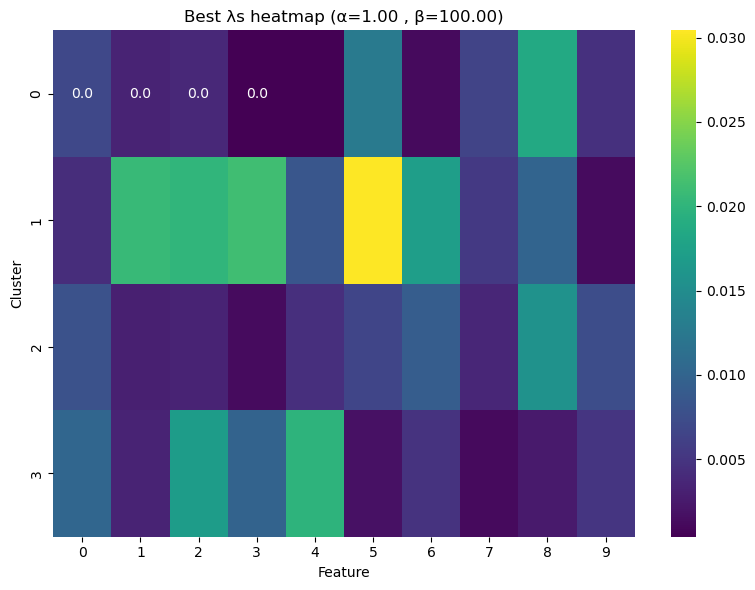

In [3]:
best_score = -np.inf
best_alpha_beta = None
best_lambdas = None
best_data = None
best_assignments = None
log_likelihoods = []

for trial in range(num_trials):
    lambdas = simulate_lambdas(alpha, beta, k, d)
    data, assignments = simulate_data(lambdas, n, k)
    ll = poisson_log_likelihood(data, lambdas, assignments)
    log_likelihoods.append(ll)
    if ll > best_score:
        best_score = ll
        best_alpha_beta = (alpha, beta)
        best_lambdas = lambdas.copy()
        best_data = data.copy()
        best_assignments = assignments.copy()

print(f"Best log-likelihood: {best_score:.2f}")
plt.figure(figsize=(8, 6))
sns.heatmap(best_lambdas, annot=True, fmt=".1f", cmap="viridis")
plt.title(f"Best λs heatmap (α={best_alpha_beta[0]:.2f} , β={best_alpha_beta[1]:.2f})")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

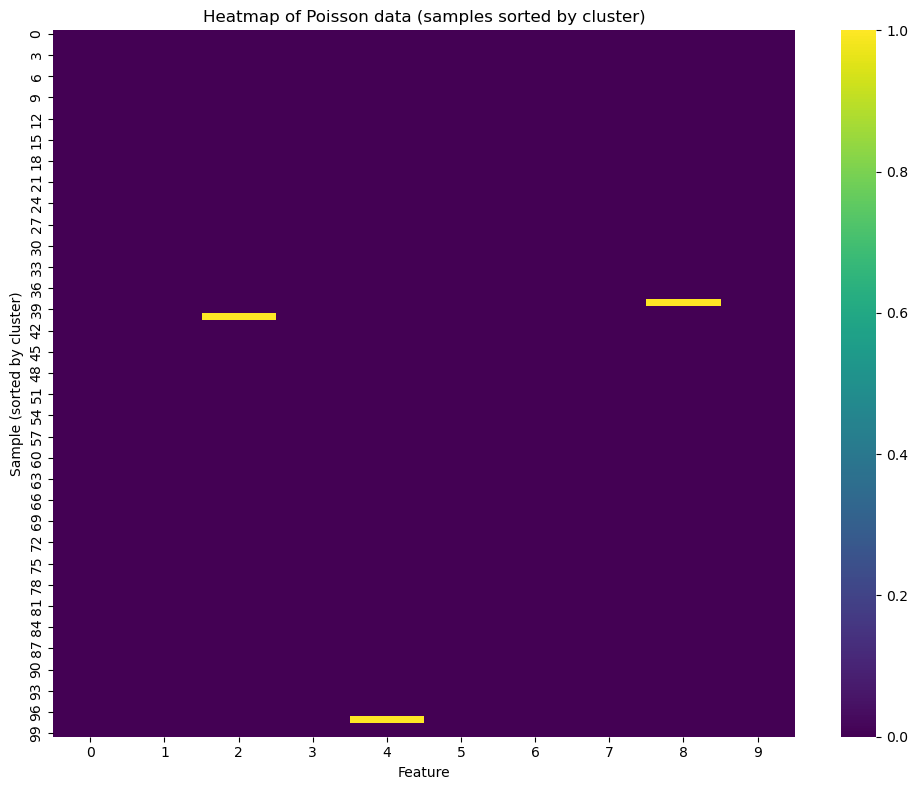

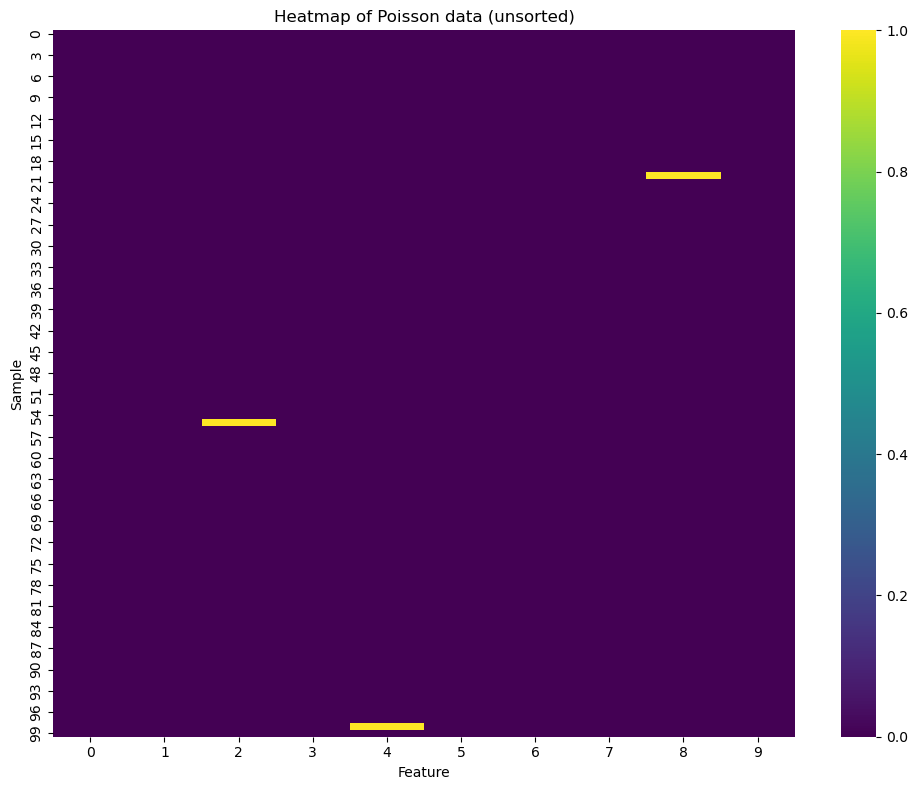

In [4]:
# Heatmap of simulated data (sorted by cluster)
sorted_idx = np.argsort(best_assignments)
sorted_data = best_data[sorted_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(sorted_data, cmap='viridis', cbar=True)
plt.title('Heatmap of Poisson data (samples sorted by cluster)')
plt.xlabel('Feature')
plt.ylabel('Sample (sorted by cluster)')
plt.tight_layout()
plt.show()

# Heatmap of simulated data (unsorted)
plt.figure(figsize=(10, 8))
sns.heatmap(best_data, cmap='viridis', cbar=True)
plt.title('Heatmap of Poisson data (unsorted)')
plt.xlabel('Feature')
plt.ylabel('Sample')
plt.tight_layout()
plt.show()

---

## When lambda variance is high , we see good quality of clustering: 

Best log-likelihood: -3816.02


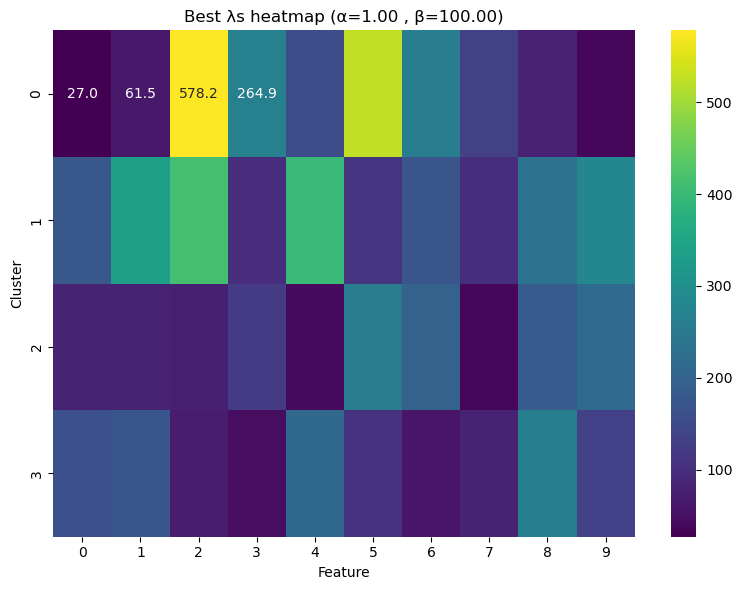

In [5]:
np.random.seed(42)

k = 4          # Number of clusters
n = 100        # Number of samples
d = 10         # Number of features
num_trials = 100  # Number of random (alpha, beta) trials

# We shall consider two cases when the lambda variance is large (small beta)
alpha = 2
beta = 0.01

def simulate_lambdas(alpha, beta, k, d):
    return np.random.gamma(alpha, 1.0/beta, size=(k, d))

def simulate_data(lambdas, n, k):
    cluster_assignments = np.random.choice(k, n)
    data = np.array([np.random.poisson(lambdas[cluster]) for cluster in cluster_assignments])
    return data, cluster_assignments

def poisson_log_likelihood(data, lambdas, cluster_assignments):
    log_likelihood = 0
    for i in range(len(data)):
        cluster = cluster_assignments[i]
        x = data[i]
        lam = lambdas[cluster]
        term1 = x * np.log(lam + 1e-50)
        term2 = -lam
        term3 = -gammaln(x + 1)
        log_likelihood += np.sum(term1 + term2 + term3)
    return log_likelihood

best_score = -np.inf
best_lambdas = None
best_data = None
best_assignments = None
log_likelihoods = []

for trial in range(num_trials):
    lambdas = simulate_lambdas(alpha, beta, k, d)
    data, assignments = simulate_data(lambdas, n, k)
    ll = poisson_log_likelihood(data, lambdas, assignments)
    log_likelihoods.append(ll)
    if ll > best_score:
        best_score = ll
        best_lambdas = lambdas.copy()
        best_data = data.copy()
        best_assignments = assignments.copy()

print(f"Best log-likelihood: {best_score:.2f}")
plt.figure(figsize=(8, 6))
sns.heatmap(best_lambdas, annot=True, fmt=".1f", cmap="viridis")
plt.title(f"Best λs heatmap (α={best_alpha_beta[0]:.2f} , β={best_alpha_beta[1]:.2f})")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

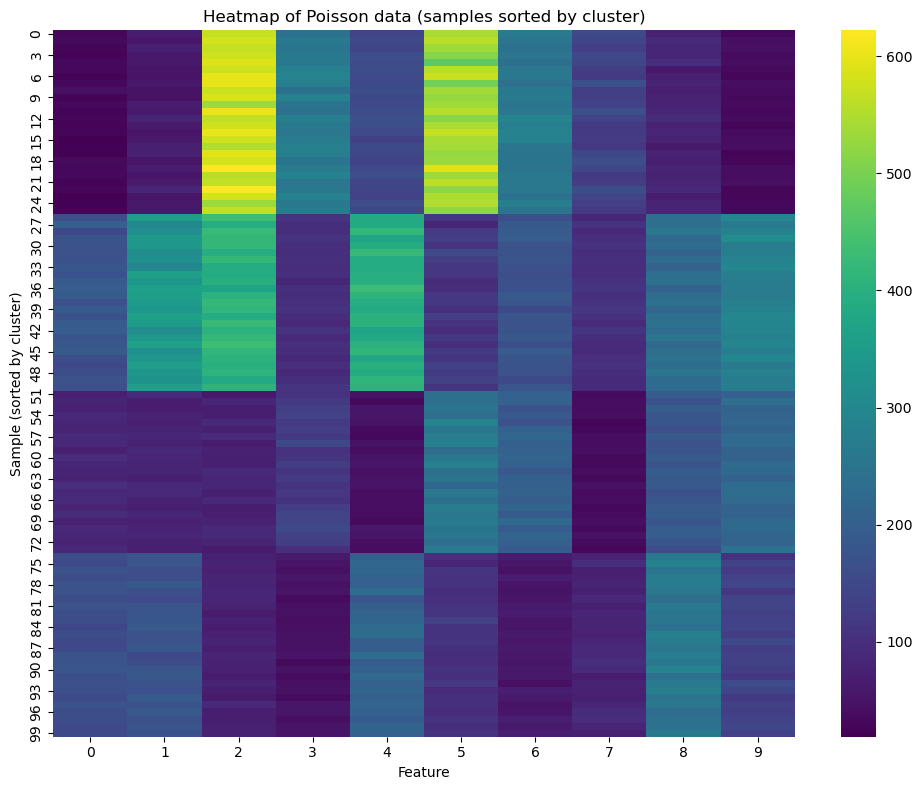

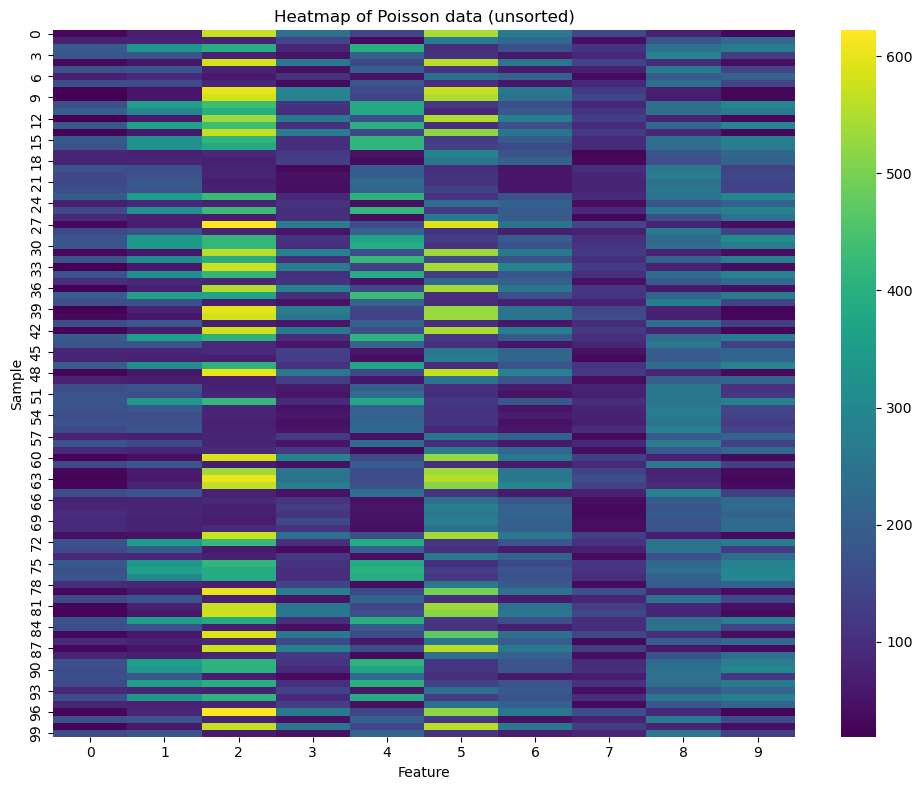

In [6]:
#Heatmap of simulated data (sorted by cluster)
sorted_idx = np.argsort(best_assignments)
sorted_data = best_data[sorted_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(sorted_data, cmap='viridis', cbar=True)
plt.title('Heatmap of Poisson data (samples sorted by cluster)')
plt.xlabel('Feature')
plt.ylabel('Sample (sorted by cluster)')
plt.tight_layout()
plt.show()

#Heatmap of simulated data (unsorted)
plt.figure(figsize=(10, 8))
sns.heatmap(best_data, cmap='viridis', cbar=True)
plt.title('Heatmap of Poisson data (unsorted)')
plt.xlabel('Feature')
plt.ylabel('Sample')
plt.tight_layout()
plt.show()

In [7]:
sorted_data

array([[ 29,  64, 568, 243, 142, 544, 264, 153,  74,  33],
       [ 34,  56, 581, 260, 150, 559, 254, 142,  90,  42],
       [ 27,  72, 568, 256, 141, 537, 246, 128,  84,  43],
       [ 26,  57, 576, 262, 162, 512, 254, 150,  84,  37],
       [ 33,  58, 591, 263, 155, 473, 240, 148,  97,  40],
       [ 32,  54, 576, 280, 159, 558, 259, 127,  58,  34],
       [ 24,  50, 600, 290, 155, 571, 261, 120,  71,  30],
       [ 32,  57, 599, 278, 151, 494, 242, 165,  76,  39],
       [ 44,  49, 573, 240, 158, 538, 262, 130,  69,  36],
       [ 24,  47, 585, 289, 151, 524, 262, 130,  77,  35],
       [ 32,  64, 534, 251, 155, 537, 254, 137,  77,  37],
       [ 24,  61, 601, 247, 160, 554, 261, 163,  84,  32],
       [ 28,  80, 564, 278, 167, 514, 290, 137,  93,  36],
       [ 25,  63, 577, 263, 161, 546, 275, 120,  77,  27],
       [ 27,  52, 602, 258, 155, 569, 283, 118,  81,  37],
       [ 19,  57, 577, 267, 135, 542, 283, 123,  77,  38],
       [ 23,  71, 549, 279, 151, 541, 254, 114,  61,  41

In [8]:
best_data

array([[ 29,  64, 568, 243, 142, 544, 264, 153,  74,  33],
       [ 74,  75,  76, 140,  35, 266, 223,  42, 177, 223],
       [189, 336, 400,  83, 397,  94, 166, 107, 243, 271],
       [176, 178,  74,  49, 208, 108,  57,  85, 285, 126],
       [ 34,  56, 581, 260, 150, 559, 254, 142,  90,  42],
       [171, 178,  77,  43, 196, 108,  60,  72, 264, 141],
       [ 71,  92,  58, 106,  49, 240, 203,  36, 193, 205],
       [159, 155,  81,  37, 175, 100,  54,  88, 236, 141],
       [ 24,  50, 600, 290, 155, 571, 261, 120,  71,  30],
       [ 21,  54, 580, 283, 139, 548, 246, 145,  67,  30],
       [165, 354, 433, 113, 386, 117, 165,  84, 236, 295],
       [200, 300, 393,  97, 383,  84, 184, 107, 238, 264],
       [ 22,  57, 532, 262, 156, 551, 276, 129,  80,  32],
       [183, 362, 432, 101, 403,  97, 165,  91, 221, 294],
       [ 25,  57, 566, 268, 147, 519, 252, 119,  83,  33],
       [188, 317, 414,  95, 414, 119, 189,  90, 236, 275],
       [172, 327, 383,  97, 412, 135, 153,  91, 228, 269

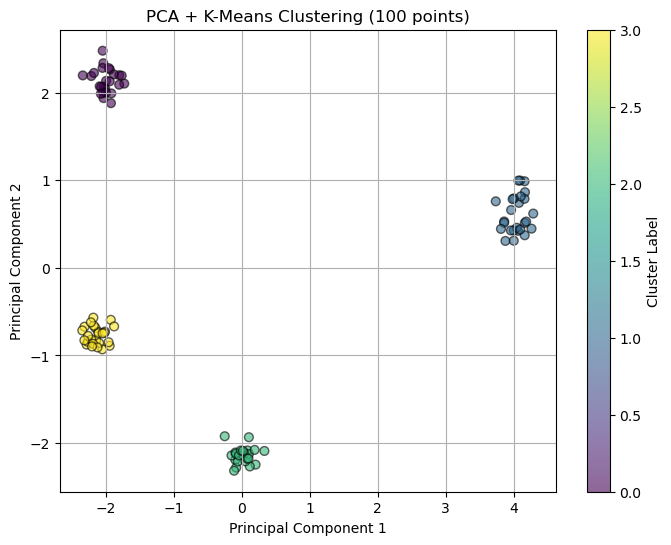

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

scaler = StandardScaler()
best_data_scaled = scaler.fit_transform(best_data)

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(best_data_scaled)

# K Means
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(best_data_scaled)


plt.figure(figsize=(8, 6))
plt.scatter(
    pca_result[:, 0], pca_result[:, 1],
    c=labels, cmap='viridis', alpha=0.6,
    s=40, edgecolors='k'
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA + K-Means Clustering (100 points)')
plt.grid(True)
plt.colorbar(label='Cluster Label')
plt.show()


In [10]:
print("Original shape:", best_data.shape)
print("After PCA:", pca_result.shape)

Original shape: (100, 10)
After PCA: (100, 2)


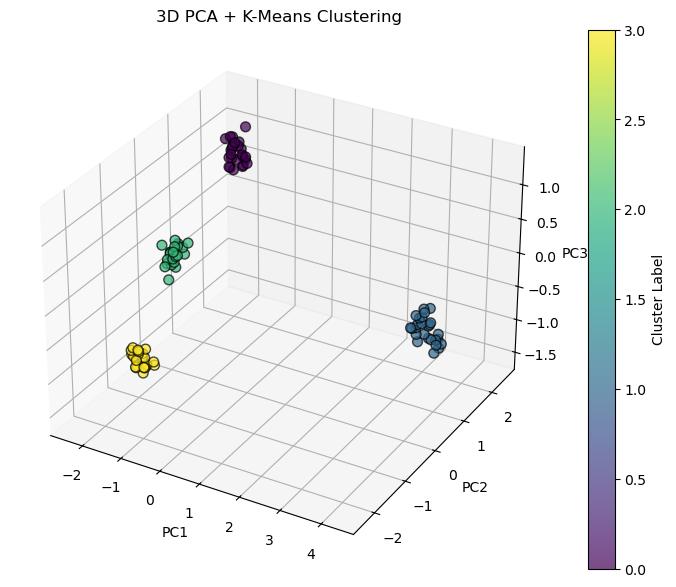

In [11]:
# Step 1: PCA with 3 components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(best_data_scaled)

# Step 2: 3D plot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
    c=labels, cmap='viridis', s=50, edgecolors='k', alpha=0.7
)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA + K-Means Clustering')
plt.colorbar(scatter, label='Cluster Label')
plt.show()


In [12]:
print("Original shape:", best_data.shape)
print("After PCA:", pca_result.shape)

Original shape: (100, 10)
After PCA: (100, 3)
